# Tecnologias e Aplicações
## Cartografia

### Pedro Capa a83170

Load the necessary packages

In [1]:
from qgis.core import *
import sys
import os
from qgis.PyQt.QtCore import QVariant
from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice
import pandas as pd

Load the Qgis information to the notebook

In [2]:
QgsApplication.setPrefixPath(r"C:\OSGeo4W64\apps\qgis", True)

qgs = QgsApplication([], True)

qgs.initQgis()

sys.path.append(r'C:\OSGeo4W64\apps\qgis\python\plugins')

Load the CSV file with information about COVID-19

In [3]:
path_to_csv = "file:///C:/Users/pmcca/Documents/04-28-2020.csv?delimiter=,"

csv_layer = QgsVectorLayer(path_to_csv, "EPID", "delimitedtext")
if not csv_layer.isValid():
    print("Layer failed to load!")
else:
    print('Load with sucess')

QgsProject.instance().addMapLayer(csv_layer)

Load with sucess


<QgsMapLayer: 'EPID' (delimitedtext)>

Load the CSV file with information about the US population

In [4]:
path_to_pop = "file:///C:/Users/pmcca/Documents/SCPRC-EST2019-18POP-RES.csv?delimiter=,"

pop_layer = QgsVectorLayer(path_to_pop, "POP", "delimitedtext")
if not pop_layer.isValid():
    print("Layer failed to load!")
else:
    print('Load with sucess')

QgsProject.instance().addMapLayer(pop_layer)

Load with sucess


<QgsMapLayer: 'POP' (delimitedtext)>

Load the SHP file with information about the US

In [5]:
path_to_shp = r"data\usa_states_map\tl_2017_us_state.shp"

shp_layer = QgsVectorLayer(path_to_shp, "US", "ogr")
if not shp_layer.isValid():
    print("Layer failed to load!")
else:
    print('Load with sucess')
    
QgsProject.instance().addMapLayer(shp_layer)

provider = shp_layer.dataProvider()

Load with sucess


Join the information about the US with information about COVID-19.

In [6]:
shpField='NAME'
csvField='Province_State'
joinObject = QgsVectorLayerJoinInfo()
joinObject.setJoinFieldName(csvField)
joinObject.setTargetFieldName(shpField)
joinObject.setJoinLayerId(csv_layer.id())
joinObject.setUsingMemoryCache(True)
joinObject.setJoinLayer(csv_layer)
shp_layer.addJoin(joinObject)

True

Join the information about the US population with the joined information in the previous cell.

In [7]:
shpField='NAME'
csvField='NAME'
joinObject = QgsVectorLayerJoinInfo()
joinObject.setJoinFieldName(csvField)
joinObject.setTargetFieldName(shpField)
joinObject.setJoinLayerId(pop_layer.id())
joinObject.setUsingMemoryCache(True)
joinObject.setJoinLayer(pop_layer)
shp_layer.addJoin(joinObject)

True

Check the kind of operations can be done with shp_layer

In [8]:
caps = shp_layer.dataProvider().capabilities()

print(shp_layer.dataProvider().capabilitiesString())

Add Features, Delete Features, Change Attribute Values, Add Attributes, Delete Attributes, Rename Attributes, Create Spatial Index, Create Attribute Indexes, Fast Access to Features at ID, Change Geometries


Check states without COVID-19 values

In [9]:
updateMap = {}
id = provider.fields().indexFromName( 'EPID_Confirmed' )
idd = provider.fields().indexFromName( 'EPID_Deaths' )

for feature in shp_layer.getFeatures():

    if feature['EPID_Confirmed'] is None:
        #Juntar o if para verificar se é possivel
        updateMap[feature.id()] = { id: 0, idd: 0 }

provider.changeAttributeValues( updateMap )

True

Delete states without population info

In [10]:
population = []
cases = []
deaths = []
updateMap = {}
delete = []

for feature in shp_layer.getFeatures():

    if feature['POP_POPESTIMATE2019'] is None:#Mudar o EPID_Confirmed
        delete.append(feature.id())
    else:
        population.append(feature['POP_POPESTIMATE2019'])
        cases.append(feature['EPID_Confirmed'])
        deaths.append(feature['EPID_Deaths'])


res = shp_layer.dataProvider().deleteFeatures(delete)
population.sort()
cases.sort()
deaths.sort()

Add fields, %Infected, %Population, %Dead, Dif(%) and PopInf(%)

The %Infected is the percentage of people with COVID-19 in that particular state in the US.

The %Population is the percentage of the population in the US in the state.

The %Dead is the percentage that dies with COVID-19 in that state in the US.

%Dif is the difference between the %Infected people and the %Dead.

And %PopInf is the ratio between the number of infected people and the population in the state.

In [11]:
if caps & QgsVectorDataProvider.AddAttributes:
    print('Add field')
    res = shp_layer.dataProvider().addAttributes(
        [QgsField('Inf(%USA)', QVariant.Double), QgsField('Pop(%USA)', QVariant.Double), 
        QgsField('Dead(%USA)', QVariant.Double), QgsField('Dif(%)', QVariant.Double), QgsField('PopInf(%)', QVariant.Double)])
    shp_layer.updateFields()

Add field


Add values to the features in the previously created fields 

In [12]:
updateMap = {}
perc_infected = provider.fields().indexFromName( 'Inf(%USA)' )
perc_pop = provider.fields().indexFromName( 'Pop(%USA)' )
perc_dead = provider.fields().indexFromName( 'Dead(%USA)' )
perc_dif = provider.fields().indexFromName( 'Dif(%)' )
perc_popInf = provider.fields().indexFromName( 'PopInf(%)' )

values_inf = sum(cases)
values_pop = sum(population)
values_dead = sum(deaths)

print(values_inf, values_pop, values_dead)

for feature in shp_layer.getFeatures():
    i = (feature['EPID_Confirmed'] / values_inf) * 100
    p = (feature['POP_POPESTIMATE2019'] / values_pop) * 100
    d = (feature['EPID_Deaths'] / values_dead) * 100
    dif = i - d
    pi = feature['EPID_Confirmed'] / feature['POP_POPESTIMATE2019']
    updateMap[feature.id()] = { perc_infected: i , perc_pop: p, perc_dead: d, perc_dif: dif, perc_popInf: pi}
provider.changeAttributeValues( updateMap )

1010818 328239523 58255


True

The following method adds a renderer to the shp_layer. This renderer makes possible the draw of the map.
This particular renderer creates a different group per state, and the color is proportional to the values.

In [13]:
def apply_graduated_symbology(target):
    target_field = target
    myRangeList = []
    
    values_list = []
    
    for feature in shp_layer.getFeatures():
        values_list.append(feature[target])
    values_list.sort()
     
    miin = min(values_list)
    maax = max(values_list)
    
    symbol = QgsSymbol.defaultSymbol(shp_layer.geometryType())     
    symbol.setColor(QColor(255, 20, 20))                              
    myRange = QgsRendererRange(0, values_list[0], symbol, 'Group 0')                   
    myRangeList.append(myRange)                                     

    i = 0
    for value in values_list:
        if i > 0:
            symbol = QgsSymbol.defaultSymbol(shp_layer.geometryType())
            red = ((values_list[i] - miin) / (maax - miin)) * 255
            symbol.setColor(QColor(255 - red, 20, 20))
            myRange = QgsRendererRange(values_list[i - 1], value, symbol, 'Group ' + str(i))
            myRangeList.append(myRange)
            i = i + 1
        else:
            i = i + 1

    myRenderer = QgsGraduatedSymbolRenderer(target_field, myRangeList)  
    myRenderer.setMode(QgsGraduatedSymbolRenderer.Custom)               

    shp_layer.setRenderer(myRenderer)                                  
    
    print(f"Graduated color scheme applied")

This particular renderer can be used with a negative and positive percentage.

In [14]:
def apply_graduated_symbology_dif(target):
    target_field = target
    myRangeList = []
    
    symbol = QgsSymbol.defaultSymbol(shp_layer.geometryType())
    symbol.setColor(QColor(255, 20, 20))
    myRange = QgsRendererRange(-100, 0, symbol, 'Group 0')
    myRangeList.append(myRange)
    
    symbol = QgsSymbol.defaultSymbol(shp_layer.geometryType())
    symbol.setColor(QColor(20, 255, 20))
    myRange = QgsRendererRange(0.00001, 100, symbol, 'Group 1')
    myRangeList.append(myRange)

    myRenderer = QgsGraduatedSymbolRenderer(target_field, myRangeList)  
    myRenderer.setMode(QgsGraduatedSymbolRenderer.Custom)               

    shp_layer.setRenderer(myRenderer)                                  
    
    print(f"Graduated color scheme applied")

Get the map information of the US layer

In [15]:
country = QgsProject.instance().mapLayersByName('US')[0]

The next cell generates the image with the renderer information made with the previous functions

In [16]:
def getImage():
    xt = country.extent()

    width  = 2000
    height = int(width*xt.height()/xt.width())
    print("Gerar mapa com {} por {}".format(width, height))

    options = QgsMapSettings()
    options.setLayers([country])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)

    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    return image

In [17]:
from IPython.display import Image

Show a color map with the values of the number of cases

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated


Graduated color scheme applied
Gerar mapa com 2000 por 292


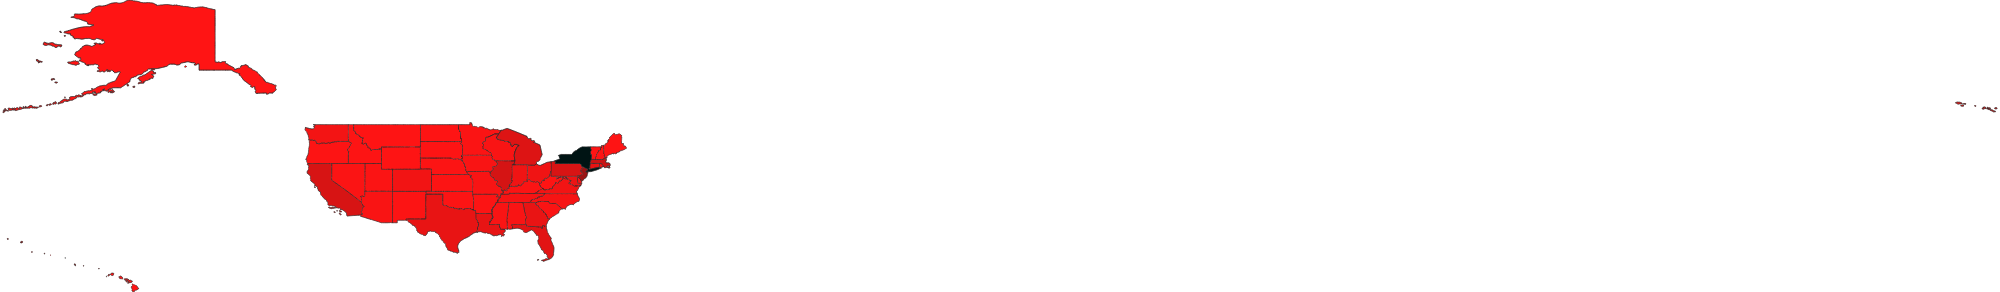

In [18]:
apply_graduated_symbology('EPID_Confirmed')

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image = getImage()
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

Color map with the balance between the infected percentage and dead percentage.
The red states the deed percentage is higher than the infected percentage. 

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated
  app.launch_new_instance()


Graduated color scheme applied
Gerar mapa com 2000 por 292


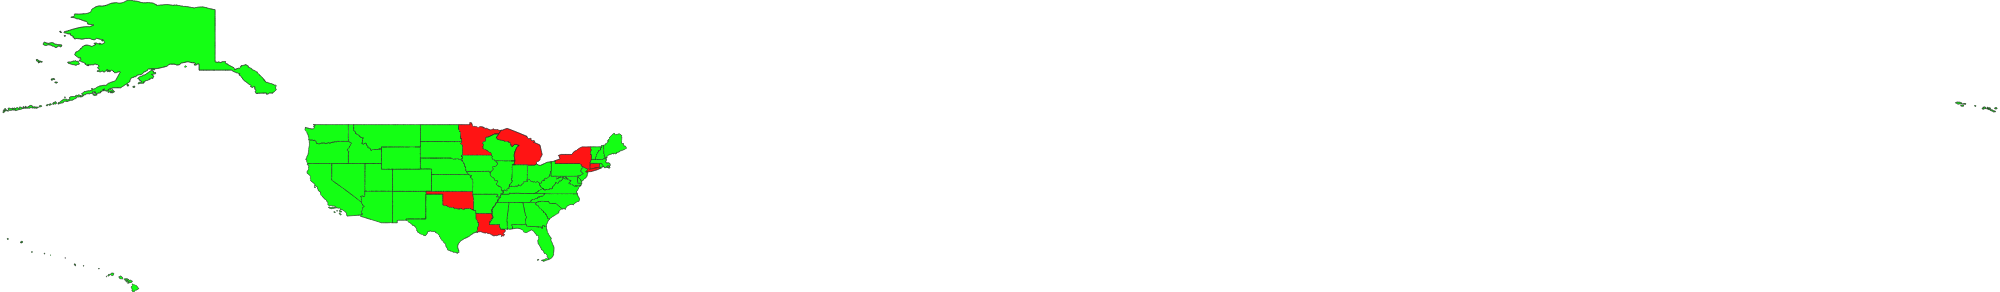

In [19]:
apply_graduated_symbology_dif('Dif(%)')

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image = getImage()
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

In [20]:
import matplotlib.pyplot as plt

The next cell shows a pie plot with the percentage of cases in the US between the states with more than 1 % of cases in the US

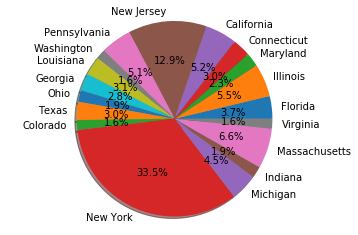

In [21]:
values = []
labels = []
for feature in shp_layer.getFeatures():
    if feature['Inf(%USA)'] > 1:
        values.append(feature['EPID_Confirmed'])
        labels.append(feature['NAME'])

plt.pie(values, labels=labels, shadow=True, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [22]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

Graphic bar with the percentage of the population infected

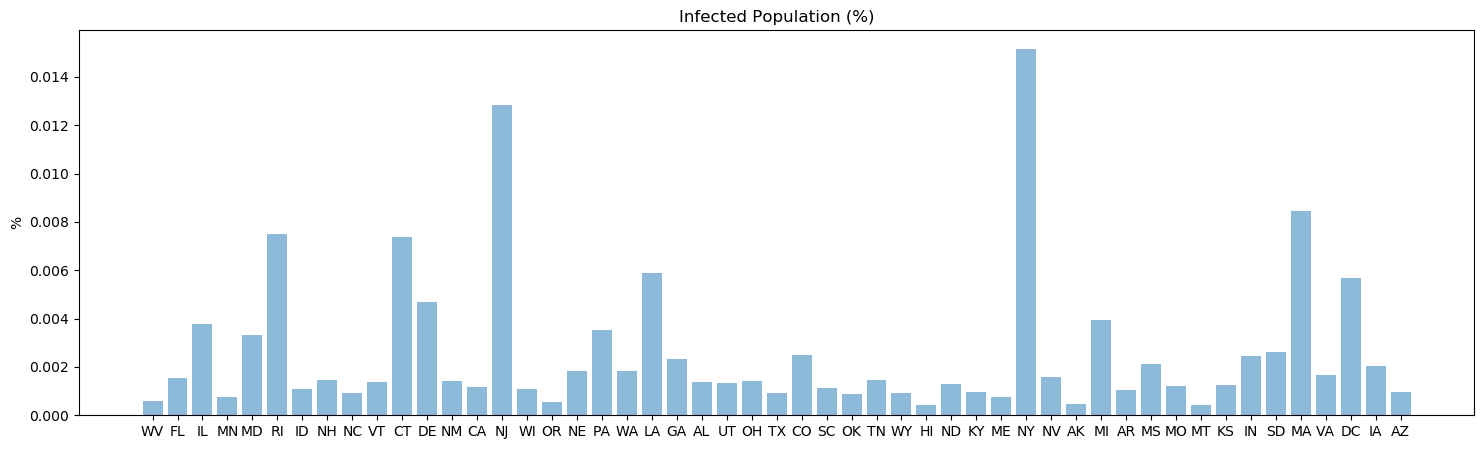

In [23]:
objects = []
performance = []

for feature in shp_layer.getFeatures():
    objects.append(feature['STUSPS'])
    performance.append(feature['PopInf(%)'])

y_pos= list(range(0, len(objects)))

plt.figure(figsize=(18,5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('%')
plt.title('Infected Population (%)')

plt.show()

In [24]:
qgs.exitQgis()